In [1]:
# Data processing
# ==============================================================================

import pandas as pd
import numpy as np

# Data plotting
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
# ==============================================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb

# Memory Optimization
# ==============================================================================

import gc
gc.collect()

0

In [2]:
# Read the data
# ==============================================================================

mail_data = pd.read_csv('~/OpenDoor/data/fct_mailers.csv')
mail_data.head() 

,mail_id,home_id,mail_date
0,ID31616861,187865,2023-01-01T00:00:00.000Z
1,ID97896997,2356628,2023-01-01T00:00:00.000Z
2,ID24728546,439113,2023-01-01T00:00:00.000Z
3,ID45212612,1860369,2023-01-01T00:00:00.000Z
4,ID69524398,511384,2023-01-01T00:00:00.000Z


In [3]:
# Read the data
# ==============================================================================
 
home_data = pd.read_csv('~/OpenDoor/data/dim_homes.csv')
home_data.head() 

,home_id,market,home_type,est_home_value,quality_score,home_size_sqft,nbr_bedrooms,nbr_bathrooms,construction_year,last_transaction_year,last_transaction_value,owner_name,est_owner_age
0,0,New York,townhome,1.155426e+06,3,2519,5,3,2009,2023,1.155426e+06,Allison Hill,51
1,1,New York,townhome,7.186668e+05,83,1548,3,3,1992,1992,2.012799e+05,Noah Rhodes,42
2,2,Phoenix,townhome,3.131741e+05,50,1164,1,1,1997,1997,6.477227e+04,Angie Henderson,21
3,3,Dallas-Ft. Worth,single-family detached,2.042423e+06,61,3975,4,2,1982,2010,1.622118e+06,Daniel Wagner,50
4,4,Dallas-Ft. Worth,townhome,7.201744e+05,51,1150,2,3,2015,2015,5.537206e+05,Cristian Santos,29


In [4]:
# Read the data
# ==============================================================================

offer_data = pd.read_csv('~/OpenDoor/data/fct_offers.csv')
offer_data.head()

,offer_id,home_id,offer_date,offer_amount,offer_accepted
0,5c5e6b9d-bb09-48f8-80fe-886cd6891aa2,24,2023-07-11T00:00:00.000+0000,1.024258e+06,False
1,ab61dc2e-d9b2-47a5-a391-fcb9706b19ee,1205,2023-07-23T00:00:00.000+0000,1.251422e+06,True
2,a1fc3a7a-dbfd-41e6-90a5-a9bb5ae80776,1623,2023-04-05T00:00:00.000+0000,7.463413e+05,False
3,be8b8dbd-4336-43f0-aaa1-f98dc2eda2e0,2705,2023-03-16T00:00:00.000+0000,6.473678e+05,False
4,d8cf526f-6440-4b8a-9a4c-8b247e324fef,3168,2023-02-26T00:00:00.000+0000,2.298493e+05,False


In [5]:
# Extract just the year
mail_data['year'] = mail_data['mail_date'].str[:4]
mail_data.head()

,mail_id,home_id,mail_date,year
0,ID31616861,187865,2023-01-01T00:00:00.000Z,2023
1,ID97896997,2356628,2023-01-01T00:00:00.000Z,2023
2,ID24728546,439113,2023-01-01T00:00:00.000Z,2023
3,ID45212612,1860369,2023-01-01T00:00:00.000Z,2023
4,ID69524398,511384,2023-01-01T00:00:00.000Z,2023


In [6]:
print(mail_data['mail_id'].nunique())

120000


In [7]:
print(home_data['home_id'].nunique())

2500000


In [8]:
print(mail_data.shape)
print(home_data.shape)
print(offer_data.shape)

(120000, 4)
(2500000, 13)
(7191, 5)


In [29]:
# sanity check to understand how home_id links all the tables
# ==============================================================================

# Check if all values in mail_data.home_id occur in home_data.home_id
all_t1_in_t2 = mail_data['home_id'].isin(home_data['home_id']).all()

# Check if all values in home_data.home_id occur in offer_data.home_id
all_t2_in_t3 = home_data['home_id'].isin(offer_data['home_id']).all()

# Check if all values in mail_data.home_id occur in offer_data.home_id
all_t1_in_t3 = mail_data['home_id'].isin(offer_data['home_id']).all()

# Check if all values in offer_data.home_id occur in mail_data.home_id
all_t3_in_t1 = offer_data['home_id'].isin(mail_data['home_id']).all()

# Check if all values in offer_data.home_id occur in home_data.home_id
all_t3_in_t2 = offer_data['home_id'].isin(home_data['home_id']).all()

print(f"All values in mail_data.home_id occur in home_data.home_id: {all_t1_in_t2}")
print(f"All values in home_data.home_id occur in offer_data.home_id: {all_t2_in_t3}")
print(f"All values in mail_data.home_id occur in offer_data.home_id: {all_t1_in_t3}")
print(f"All values in offer_data.home_id occur in mail_data.home_id: {all_t3_in_t1}")
print(f"All values in offer_data.home_id occur in home_data.home_id: {all_t3_in_t2}")

All values in mail_data.home_id occur in home_data.home_id: True
All values in home_data.home_id occur in offer_data.home_id: False
All values in mail_data.home_id occur in offer_data.home_id: False
All values in offer_data.home_id occur in mail_data.home_id: True
All values in offer_data.home_id occur in home_data.home_id: True


In [10]:
# sanity check
# =============================================================================
 
print(offer_data['offer_id'].nunique())
print(offer_data['home_id'].nunique())
print(offer_data['offer_date'].nunique())

7191
7167
380


In [11]:
# Find duplicate values in the 'home_id' column
# =============================================================================

duplicates = offer_data[offer_data.duplicated('home_id')]

# Print the duplicate values
print("Number of duplicate home_ids:")
print(len(duplicates))

Duplicate home_ids:
24


In [12]:
# Sort the DataFrame by 'Score' column in descending order
offer_data = offer_data.sort_values('offer_amount', ascending=False)

# Drop duplicates based on 'Name' column, keeping the first occurrence (highest score)
offer_data = offer_data.drop_duplicates('home_id', keep='first')

# Print the resulting DataFrame
print("DataFrame after dropping duplicates and keeping the highest score:")
print(offer_data.shape)

DataFrame after dropping duplicates and keeping the highest score:
(7167, 5)


In [13]:
# Get value counts of column home_id for each year
# ==============================================================================

counts_by_year = mail_data.groupby('year')[['home_id']].apply(lambda x: x.apply(pd.value_counts)).unstack(fill_value=0)

# Sum value counts of column B for each year
sum_B_by_year = counts_by_year.sum(axis=1)

print(sum_B_by_year)

year
2023    120000
dtype: int64


/var/folders/mh/crzr9fvs1hz479vjn820n9kc0000gq/T/ipykernel_4738/2157085147.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts_by_year = mail_data.groupby('year')[['home_id']].apply(lambda x: x.apply(pd.value_counts)).unstack(fill_value=0)


In [14]:
# Explore the distribution of the target variable (offer_accepted) in the offer_data DataFrame
# ==============================================================================

offer_accepted_counts = offer_data['offer_accepted'].value_counts(normalize=True)
print("Distribution of Offer Accepted (Target Variable):")
print(offer_accepted_counts)

Distribution of Offer Accepted (Target Variable):
offer_accepted
False    0.830752
True     0.169248
Name: proportion, dtype: float64


In [15]:
# Handle missing values and ensure correct data types
home_data['construction_year'] = pd.to_numeric(home_data['construction_year'], errors='coerce')
home_data['last_transaction_year'] = pd.to_numeric(home_data['last_transaction_year'], errors='coerce')
home_data['est_home_value'] = pd.to_numeric(home_data['est_home_value'], errors='coerce')
home_data['home_size_sqft'] = pd.to_numeric(home_data['home_size_sqft'], errors='coerce')

In [16]:
# Calculate home age
home_data['home_age'] = 2024 - home_data['construction_year']

# Calculate years since last transaction
home_data['years_since_last_transaction'] = 2024 - home_data['last_transaction_year']

# Calculate home value per square foot
home_data['value_per_sqft'] = home_data['est_home_value'] / home_data['home_size_sqft']

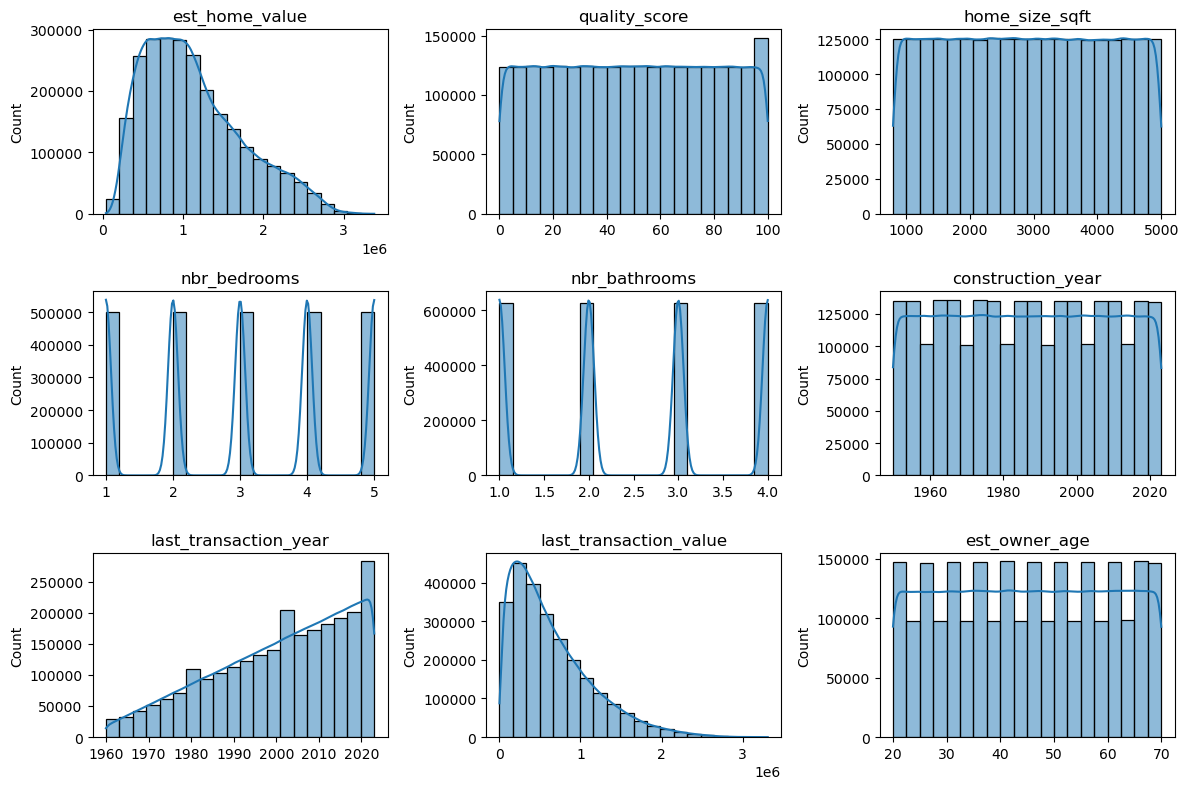

In [17]:
# Visualization of home data
# ==============================================================================

# Select numerical columns for visualization
numerical_cols = ['est_home_value', 'quality_score', 'home_size_sqft', 'nbr_bedrooms', 'nbr_bathrooms', 'construction_year', 'last_transaction_year', 'last_transaction_value', 'est_owner_age']

# Plot histograms for numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(home_data[col], bins=20, kde=True)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

#### Offer Acceptance Rates by Home Type and Market

In [18]:
offer_data.columns

Index(['offer_id', 'home_id', 'offer_date', 'offer_amount', 'offer_accepted'], dtype='object')

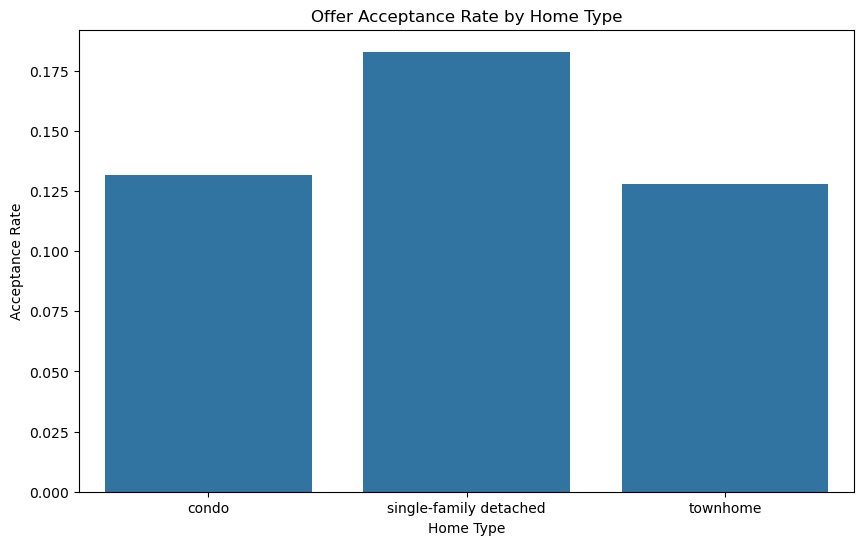

In [19]:
# Merge datasets for offer analysis
offers_merged = pd.merge(offer_data, home_data, on='home_id', how='inner')

# Offer acceptance rate by home type
acceptance_by_type = offers_merged.groupby('home_type')['offer_accepted'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=acceptance_by_type, x='home_type', y='offer_accepted')
plt.title('Offer Acceptance Rate by Home Type')
plt.xlabel('Home Type')
plt.ylabel('Acceptance Rate')
plt.show()

#### Offer acceptance rate by market

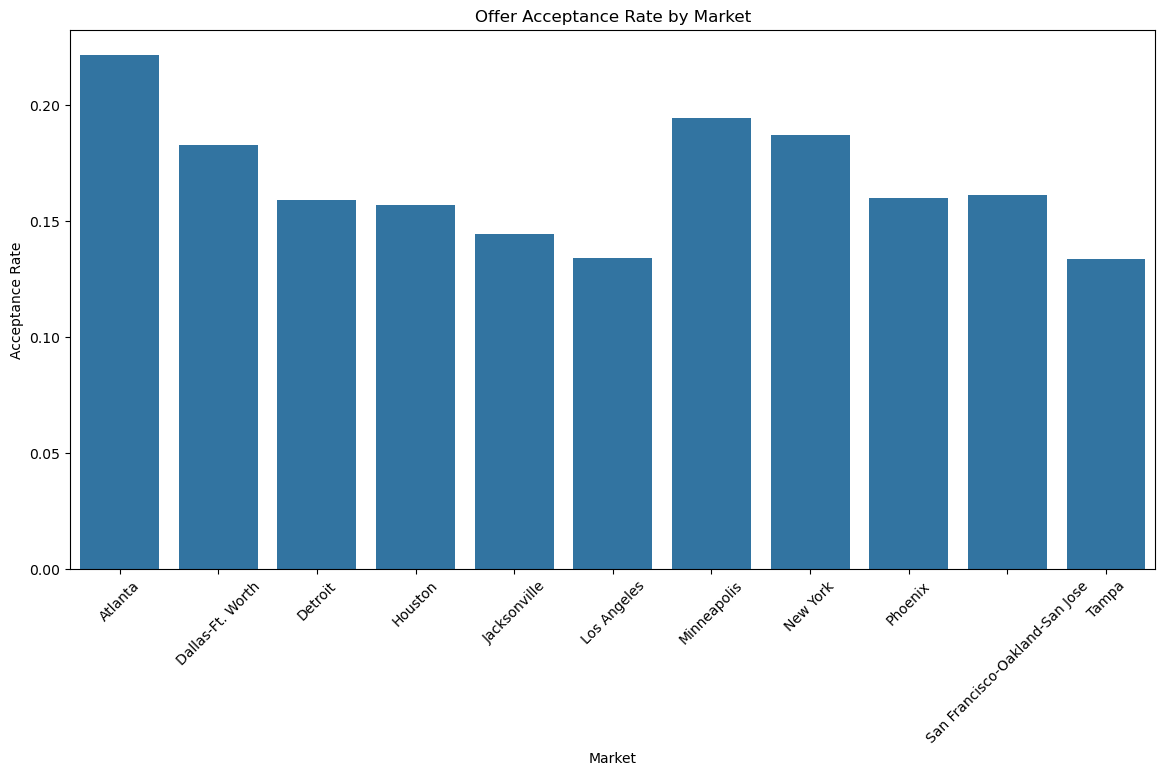

In [20]:
# Offer acceptance rate by market
acceptance_by_market = offers_merged.groupby('market')['offer_accepted'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=acceptance_by_market, x='market', y='offer_accepted')
plt.title('Offer Acceptance Rate by Market')
plt.xlabel('Market')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.show()

can combine market and type of homes to specifically target the audience

In [21]:
offers_merged.head()

,offer_id,home_id,offer_date,offer_amount,offer_accepted,market,home_type,est_home_value,quality_score,home_size_sqft,nbr_bedrooms,nbr_bathrooms,construction_year,last_transaction_year,last_transaction_value,owner_name,est_owner_age,home_age,years_since_last_transaction,value_per_sqft
0,87bd3a28-8747-48f2-af0d-f110879b2b40,988516,2023-11-25T00:00:00.000+0000,1.436328e+06,False,Atlanta,single-family detached,1.497384e+06,11,2477,4,1,1990,2010,1.124585e+06,Brittany Fletcher,40,34,14,604.515084
1,6bacbed1-3a63-458f-b2ee-ed0543bc4f46,1203262,2023-04-12T00:00:00.000+0000,1.434981e+06,True,Atlanta,single-family detached,1.495936e+06,48,2545,1,2,2017,2017,1.170629e+06,Angela Fisher,50,7,7,587.793923
2,b0ba7f80-25d0-417c-9f55-fe0cda32df4d,705776,2023-10-31T00:00:00.000+0000,1.432819e+06,True,Dallas-Ft. Worth,single-family detached,1.499473e+06,2,3038,1,2,1999,2017,1.357568e+06,Rebecca Parks,53,25,7,493.572473
3,40539879-b7e6-4026-b3f0-14d7e0a478c1,274580,2023-03-25T00:00:00.000+0000,1.432775e+06,False,Dallas-Ft. Worth,single-family detached,1.499425e+06,13,2814,5,2,1963,1996,8.396210e+05,Dr. Michael Rice II,45,61,28,532.844817
4,152129d8-8d76-4808-95b0-f73bb6383b7d,676481,2023-09-16T00:00:00.000+0000,1.432341e+06,False,Dallas-Ft. Worth,single-family detached,1.498954e+06,40,3004,2,3,1963,2005,1.145212e+06,Miranda Pacheco DDS,52,61,19,498.986073


In [22]:
offers_merged.shape

(7167, 20)

In [23]:
offers_merged['home_type'].nunique()

3

In [24]:
offers_merged['market'].nunique()

11

In [25]:
# Prepare features and target variable
X = offers_merged.drop(columns=['offer_accepted', 'home_id', 'offer_id', 'offer_date', 'owner_name'])

# Apply one-hot encoding using pd.get_dummies
X = pd.get_dummies(X, columns=['market', 'home_type'])
y = offers_merged['offer_accepted']

print(X.columns)

Index(['offer_amount', 'est_home_value', 'quality_score', 'home_size_sqft',
       'nbr_bedrooms', 'nbr_bathrooms', 'construction_year',
       'last_transaction_year', 'last_transaction_value', 'est_owner_age',
       'home_age', 'years_since_last_transaction', 'value_per_sqft',
       'market_Atlanta', 'market_Dallas-Ft. Worth', 'market_Detroit',
       'market_Houston', 'market_Jacksonville', 'market_Los Angeles',
       'market_Minneapolis', 'market_New York', 'market_Phoenix',
       'market_San Francisco-Oakland-San Jose', 'market_Tampa',
       'home_type_condo', 'home_type_single-family detached',
       'home_type_townhome'],
      dtype='object')


In [26]:
print(X.shape)
print(y.shape)

(7167, 27)
(7167,)


In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced_subsample', max_depth=10)
model.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc}")

AUC-ROC: 0.5470756864618758


In [ ]:
# Predict probabilities for all homes
home_data = pd.get_dummies(home_data, columns=['market', 'home_type'])

home_data['predicted_prob'] = model.predict_proba(home_data.drop(columns=['home_id', 'owner_name']))[:, 1]

# Select top 10,000 homes
top_homes = home_data.nlargest(10000, 'predicted_prob')

# Output the list of home IDs
top_home_ids = top_homes['home_id'].tolist()
print(top_home_ids)

In [29]:
# Train the model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Metrics
lr_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_lr)
}

print("Logistic Regression Metrics:")
print(lr_metrics)
print(classification_report(y_test, y_pred_lr))

Logistic Regression Metrics:
{'Accuracy': 0.8193189715079917, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC-ROC': 0.6065864161284008}
              precision    recall  f1-score   support

       False       0.82      1.00      0.90      1179
        True       0.00      0.00      0.00       260

    accuracy                           0.82      1439
   macro avg       0.41      0.50      0.45      1439
weighted avg       0.67      0.82      0.74      1439



/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: Undefined

In [30]:
# Train the model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Metrics
svm_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_svm)
}

print("SVM Metrics:")
print(svm_metrics)
print(classification_report(y_test, y_pred_svm))

SVM Metrics:
{'Accuracy': 0.8193189715079917, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC-ROC': 0.5124779800352319}
              precision    recall  f1-score   support

       False       0.82      1.00      0.90      1179
        True       0.00      0.00      0.00       260

    accuracy                           0.82      1439
   macro avg       0.41      0.50      0.45      1439
weighted avg       0.67      0.82      0.74      1439



/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a81060586/anaconda3/envs/openDoor/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

In [31]:
# Train the model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
xgb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_xgb)
}

print("XGBoost Metrics:")
print(xgb_metrics)
print(classification_report(y_test, y_pred_xgb))

XGBoost Metrics:
{'Accuracy': 0.8012508686587908, 'Precision': 0.24, 'Recall': 0.046153846153846156, 'F1 Score': 0.07741935483870968, 'AUC-ROC': 0.5424022966007699}
              precision    recall  f1-score   support

       False       0.82      0.97      0.89      1179
        True       0.24      0.05      0.08       260

    accuracy                           0.80      1439
   macro avg       0.53      0.51      0.48      1439
weighted avg       0.72      0.80      0.74      1439



In [ ]:
# Combine all metrics into a single DataFrame
metrics_df = pd.DataFrame(
    [lr_metrics, svm_metrics, xgb_metrics],
    index=['Logistic Regression', 'SVM', 'XGBoost']
)

# Display the metrics
print(metrics_df)

# Plot comparison of metrics
metrics_df.plot(kind='bar', figsize=(14, 8), rot=0)
plt.title('Comparison of Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Algorithm')
plt.legend(loc='lower right')
plt.show()

Predict Offer Acceptance Probabilities for All Homes

In [ ]:
# Standardize the features for all homes
X_all = dim_homes.drop(columns=['home_id'])
X_all = pd.get_dummies(X_all, columns=['home_type', 'market'])
X_all_scaled = scaler.transform(X_all)

# Predict probabilities using the best model (replace with your chosen model)
best_model = xgb_model  # Replace with the model that performed best in your comparison
predicted_probabilities = best_model.predict_proba(X_all_scaled)[:, 1]

# Add predicted probabilities to the original dataframe
dim_homes['predicted_prob'] = predicted_probabilities